# COMS 4995_002 Deep Learning Assignment 2
Due on Monday, Oct 31, 11:59pm

This assignment can be done in groups of at most 3 students. Everyone must submit on Courseworks individually.

Write down the UNIs of your group (if applicable)

Member 1: Name, UNI

Member 2: Name, UNI

Member 3: Name, UNI

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import glob
import sys
import tensorflow as tf
import math

In [2]:
# Helper functions, DO NOT modify this

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return scipy.misc.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

In [24]:
# Functions to load data, DO NOT change these

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    """
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[y] = 1
    return y_one_hot.T

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    files = get_files(folder)
    images = []
    count = 0
    
    for f in files:
        count += 1
        if count % 10000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
        img_arr = get_img_array(f).astype(np.float)
#         img_arr = img_arr.flatten() / 255.0
        images.append(img_arr)
    # X = np.column_stack(images)
    X = np.stack(images, axis=0)
    return X

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = data_root_path + 'train'
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
    print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)

In [25]:
# Load the data
data_root_path = 'cifar10-hw/'
X_train, y_train = get_train_data(data_root_path) # this may take a few minutes
X_test = get_images(data_root_path + 'test')
print('Data loading done')

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Loaded 10000/50000
Loaded 20000/50000
Loaded 30000/50000
Loaded 40000/50000
Loaded 50000/50000
Loaded 10000/10000
Data loading done


In [26]:
print(X_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000,)


In [35]:
# Group's helper function
def split(X, y, val_size):
    '''
    split the data into training and validation set
    '''
    indices = np.random.permutation(X.shape[0])
    test_num = int(val_size * X.shape[0])
    return X[indices[test_num:]], X[indices[:test_num]], y[indices[test_num:]], y[indices[:test_num]]

In [36]:
X_trn, X_val, y_trn, y_val = split(X_train, y_train, val_size=0.1)

In [38]:
print(X_trn.shape)
print(X_val.shape)
print(y_trn.shape)
print(y_val.shape)

(45000, 32, 32, 3)
(5000, 32, 32, 3)
(45000,)
(5000,)


## Part 1

#### Using TensorFlow, implement a Convolutional Neural Network to classify CIFAR10

##### • At least two Convolutional Layers followed by normalization and pooling layers. 
##### • Activation function ReLU.
##### • Optimizer: Gradient Descent
##### • At least one fully connected layer followed by softmax transformation.

In [60]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [loss_val,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

4096
Training
Iteration 0: with minibatch training loss = 4.54 and accuracy of 0.078
Iteration 100: with minibatch training loss = 2.39 and accuracy of 0.2
Iteration 200: with minibatch training loss = 1.83 and accuracy of 0.33
Iteration 300: with minibatch training loss = 1.73 and accuracy of 0.38
Iteration 400: with minibatch training loss = 1.96 and accuracy of 0.3
Iteration 500: with minibatch training loss = 1.8 and accuracy of 0.3
Iteration 600: with minibatch training loss = 1.77 and accuracy of 0.39
Iteration 700: with minibatch training loss = 1.63 and accuracy of 0.36
Epoch 1, Overall loss = 1.83 and accuracy of 0.365


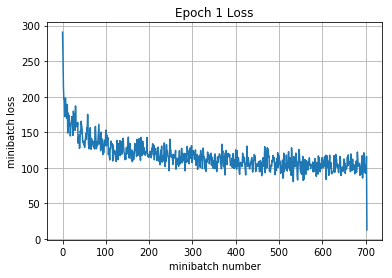

Iteration 800: with minibatch training loss = 1.56 and accuracy of 0.44
Iteration 900: with minibatch training loss = 1.54 and accuracy of 0.45


KeyboardInterrupt: 

In [61]:
H, W, T = 32, 32, 10

def model(layer_input, labels, is_training):
    F1 = 32
    layer_conv1 = tf.layers.conv2d(inputs=layer_input,filters=F1,kernel_size=[5,5],padding='same',activation=tf.nn.relu)
    layer_bn1   = tf.layers.batch_normalization(inputs=layer_conv1, training=is_training)
    layer_pool1 = tf.layers.max_pooling2d(inputs=layer_conv1, pool_size=[2, 2], strides=2)
    F2 = 64
    layer_conv2 = tf.layers.conv2d(inputs=layer_pool1,filters=F2,kernel_size=[5,5],padding='same',activation=tf.nn.relu)
    layer_bn2   = tf.layers.batch_normalization(inputs=layer_conv2, training=is_training)
    layer_pool2 = tf.layers.max_pooling2d(inputs=layer_bn2, pool_size=[2, 2], strides=2)
    flat_size = int(H/4*W/4*F2)
    print(flat_size)
    layer_pool2_flat  = tf.reshape(layer_pool2, [-1,flat_size])
    layer_dense = tf.layers.dense(inputs=layer_pool2_flat, units=1024)
    # layer_dropout = tf.layers.dropout(inputs=layer_dense, rate=0.4)
    layer_logit = tf.layers.dense(inputs=layer_dense, units=T)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int64), depth=T)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=layer_logit)
    return layer_logit, loss

# train
tf.reset_default_graph()

is_training = tf.placeholder(tf.bool)
X = tf.placeholder(tf.float32, [None, H, W, 3])
y = tf.placeholder(tf.int64, [None])
layer_logit, loss = model(X, y, is_training)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = trainer.minimize(loss)

# run_model(session, predict, loss_val, Xd, yd,
#               epochs=1, batch_size=64, print_every=100,
#               training=None, plot_losses=False):


print('Training')
run_model(session = sess,
          predict = layer_logit,
          loss_val = loss,
          Xd = X_trn,
          yd = y_trn,
          epochs=10,
          batch_size=64,
          print_every=100,
          training=train,
          plot_losses=True)
print('Validation')
run_model(sess,layer_logit,loss,X_val,y_val,1,64)

In [ ]:
layer_dimensions = [X_train.shape[0], ..., 10]  # including the input and output layers
NN = NeuralNetwork(layer_dimensions)
NN.train(X_train, y_train, iters=, alpha=, batch_size=, print_every=)

In [ ]:
y_predicted = NN.predict(X_test)
save_predictions('ans1-uni', y_predicted)

In [ ]:
# test if your numpy file has been saved correctly
loaded_y = np.load('ans1-uni.npy')
print(loaded_y.shape)
loaded_y[:10]

## Part 2: improve the performance and generalization of the Convolutional Neural Network
#### Add dropout and L2 regularization

In [ ]:
NN2 = NeuralNetwork(layer_dimensions, drop_prob=0, reg_lambda=0)
NN2.train(X_train, y_train, iters=1000, alpha=0.00001, batch_size=1000, print_every=10)

In [ ]:
y_predicted2 = NN2.predict(X)
save_predictions(y_predicted, 'ans2-uni')